In [21]:

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC
from itertools import product
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.ensemble import (RandomForestClassifier,RandomForestRegressor,GradientBoostingClassifier,GradientBoostingRegressor,BaggingClassifier,VotingClassifier,AdaBoostClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.externals.six import StringIO
#from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
#from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,roc_auc_score,
                             f1_score,accuracy_score,confusion_matrix,mean_absolute_error,r2_score,mean_squared_error)
import datetime

from datetime import datetime 

import time
import os
import sys

from scipy import misc
from scipy.stats import randint


from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA

from xgboost import XGBClassifier
import xgboost as xgb

import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
df=pd.read_csv('./santandar/train.csv')

In [3]:
df.describe()
df.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

In [3]:
df.shape

(200000, 202)

In [4]:
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [11]:
df[df.columns[2:]].std().plot('hist')
plt.title('Distribution of stds of all columns')

ImportError: matplotlib is required for plotting.

In [ ]:
df[df.columns[2:]].mean().plot('hist');
plt.title('Distribution of means of all columns');

In [12]:
df['target'].value_counts(normalize=True)

0    0.89951
1    0.10049
Name: target, dtype: float64

In [13]:
corrs = df.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(30)

,level_0,level_1,0
40170,target,var_80,0.057609
40171,var_80,target,0.057609
40172,var_166,target,0.057773
40173,target,var_166,0.057773
40174,var_99,target,0.058367
40175,target,var_99,0.058367
40176,target,var_21,0.058483
40177,var_21,target,0.058483
40178,target,var_22,0.060558
40179,var_22,target,0.060558


In [14]:

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


In [16]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

params = {
        'learning_rate': [0.02,0.1],
        'min_child_weight': [1, 10],
        'gamma': [0.5],
        'subsample': [0.6],
        'colsample_bytree': [0.6, 0.8],
        'max_depth': [3]
        }

In [17]:
xgb = XGBClassifier( n_estimators=600, objective='binary:logistic', nthread=1)

In [18]:
train_features1=df["target"]
train_labels1=df.drop('ID_code',axis=1)
train_labels1=train_labels1.drop('target',axis=1)

In [19]:
folds = 5
param_comb = 5
X=train_labels1
Y=train_features1
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X,Y), verbose=3, random_state=1001 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X, Y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed: 104.2min finished



 Time taken: 2 hours 5 minutes and 20.46 seconds.


In [20]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)


 All results:
{'param_max_depth': masked_array(data=[3, 3, 3, 3, 3],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'mean_score_time': array([3.31735166, 3.79354151, 3.2912964 , 3.24342807, 2.62801949]), 'std_fit_time': array([ 4.61134417, 24.4405644 , 15.02619734, 13.75418231, 49.9394924 ]), 'mean_train_score': array([0.93684973, 0.93584689, 0.87849437, 0.87803028, 0.93523906]), 'split1_test_score': array([0.89059469, 0.89115057, 0.84878125, 0.84897039, 0.89025451]), 'param_subsample': masked_array(data=[0.6, 0.6, 0.6, 0.6, 0.6],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'split2_train_score': array([0.93766931, 0.93664313, 0.87910397, 0.87857452, 0.93591828]), 'rank_test_score': array([2, 1, 5, 4, 3], dtype=int32), 'split0_test_score': array([0.88991025, 0.89058204, 0.85013696, 0.85069768, 0.889263  ]), 'param_learning_rate': masked_array(data=[0.1, 0.1, 0.02, 0.02

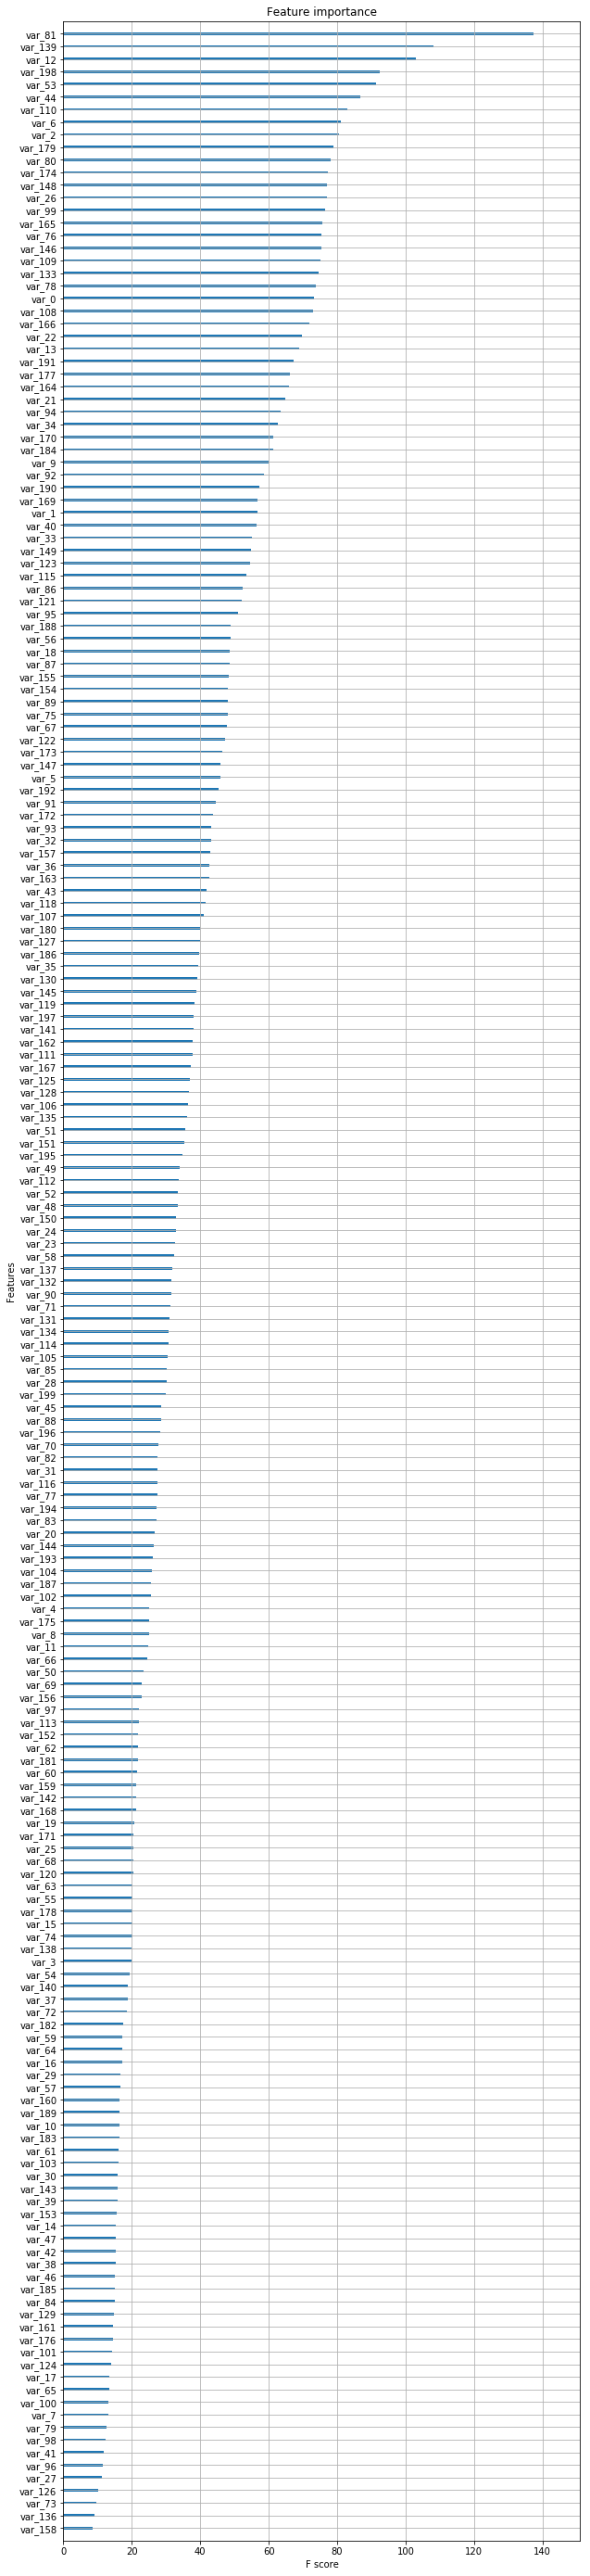

In [24]:
_, ax = plt.subplots(figsize=(10, 50))
xgb.plot_importance(random_search.best_estimator_,ax=ax,importance_type='gain',show_values=False)

In [27]:
random_search.best_estimator_.save_model('0002.model')
bst = xgb.Booster({'nthread': 4}) 
bst.load_model('0002.model')

In [ ]:
df_test=pd.read_csv('./santandar/test.csv')
df_label_test=df_test.drop('ID_code',axis=1)
y_test = random_search.predict(df_label_test)
y_pred=pd.DataFrame(y_test)
df_answer=pd.concat([df_test["ID_code"],y_pred],axis=1)
df_answer.to_csv('./santandar/submission_xgbt.csv',index=False)

In [13]:
bst = xgb.Booster({'nthread': 4}) 
bst.load_model('0001.model')


In [14]:
df_test=pd.read_csv('./santandar/test.csv')
df_label_test=df_test.drop('ID_code',axis=1)


In [15]:
dtest = xgb.DMatrix(df_label_test)
ypred = bst.predict(dtest)



In [19]:
y_pred=pd.DataFrame(ypred)
df_answer=pd.concat([df_test["ID_code"],y_pred],axis=1)
df_answer.to_csv('./santandar/submission_xgbt.csv',index=False)

In [ ]:
y_train, y_test, X_train, X_test = train_test_split(train_features1, train_labels1,
                                                    test_size=0.70, 
                                                    random_state=0)

In [4]:
def get_score(clf, train_features, train_labels):
    X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.4, random_state=0)
    clf.fit(X_train, y_train)
    print clf.score(X_test, y_test)

def get_accuracy(clf, train_features, train_labels):
    scores = cross_validation.cross_val_score(clf, train_features, train_labels, cv=10)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

def random_searchSVM(train_features, train_labels, n_jobs,objective):
    param_dist = {
#       {'C': [1, 10, 100], 'kernel': ['linear']},
       #'C': [1,10,50,100], 'gamma': [0.0001, 0.001], 'kernel': ['rbf','linear']}
        'C': [1], 'gamma': [0.001], 'kernel': ['rbf']}
    

    clf = GridSearchCV(svm.SVC(class_weight="balanced"), param_dist,n_jobs=n_jobs,scoring=objective)
    clf.fit(train_features, train_labels)
    return clf.best_estimator_,clf.best_score_,clf.best_params_

def random_searchGB(train_features, train_labels, n_jobs,objective):
    param_dist = {'n_estimators': randint(5, 300),
                   'min_samples_leaf': randint(5, 30),
                   'max_depth': randint(5, 10),
                   'learning_rate': [0.05,0.001]
                  }

    clf = RandomizedSearchCV(GradientBoostingClassifier(),param_dist,n_jobs=n_jobs,scoring=objective)
    clf.fit(train_features, train_labels)
    return clf.best_estimator_,clf.best_score_,clf.best_params_

def random_searchRF(train_features, train_labels, n_jobs,objective):
    param_dist = {
        'n_estimators'      : randint(5, 300),
        'max_features'      : randint(3, 20),
        'min_samples_split' : randint(3, 100),
        'max_depth'         : randint(3, 100)}

    clf = RandomizedSearchCV(RandomForestClassifier(class_weight="balanced"), param_dist,n_jobs=n_jobs,scoring=objective)
    clf.fit(train_features, train_labels)
    return clf.best_estimator_,clf.best_score_,clf.best_params_

def random_searchVC(train_features,train_labels,n_jobs,objective):
    clf1 = LogisticRegression(random_state=1,class_weight="balanced")
    clf2 = RandomForestClassifier(random_state=1,class_weight="balanced")
    clf3 = GaussianNB()
    eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')
    params = {'lr__C': randint(1, 300), 'rf__n_estimators': randint(5, 300),'rf__max_features':randint(3, 20),'rf__min_samples_split' : randint(3, 100),'rf__max_depth':randint(3, 100)}
    clf = RandomizedSearchCV(estimator=eclf,param_distributions=params,n_jobs=n_jobs,scoring=objective)
    clf.fit(train_features, train_labels)
    return clf.best_estimator_,clf.best_score_,clf.best_params_

def random_searchAB(train_features,train_labels,n_jobs,objective):
    param_dist = {
        'algorithm'      : ['SAMME', 'SAMME.R'],
        'n_estimators'      : randint(5, 300)}
    bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))
    clf = RandomizedSearchCV(estimator=bdt,param_distributions=param_dist,n_jobs=n_jobs,scoring=objective)
    clf.fit(train_features, train_labels)
    return clf.best_estimator_,clf.best_score_,clf.best_params_ 

def random_searchNC(train_features,train_labels,n_jobs,objective):
    param_dist = {
        'activation'      : ['identity', 'logistic', 'tanh', 'relu'],
        'hidden_layer_sizes' : [(5,2), (10,5),(10,20,5),(5,10,10,5)],
        'alpha' : [1e-5,1e-4,1e-3],
        'solver' : ['lbfgs', 'sgd', 'adam']}
      
    clf = GridSearchCV(estimator= MLPClassifier(),param_grid=param_dist,n_jobs=n_jobs,scoring=objective)
    clf.fit(train_features, train_labels)
    return clf.best_estimator_,clf.best_score_,clf.best_params_  

def best_estimater(train_features,train_labels,test_features,test_labels,objective):
    start_time = time.time()
    n_jobs = 30

    #objective = 'f1' or 'accuracy' or 'recall' or 'roc_auc'
    a_RF,b_RF,c_RF=random_searchRF(train_features, train_labels,n_jobs,objective)
  
    print("---RF finished %s seconds ---" % round(time.time() - start_time,2))
    duration_time = time.time()
  
    a_GB,b_GB,c_GB=random_searchGB(train_features, train_labels,n_jobs,objective)
  
    print("---GB finished %s seconds ---" % round(time.time() - duration_time,2))
    duration_time = time.time()
    ''' 
    a_SVM,b_SVM,c_SVM=random_searchSVM(train_features, train_labels,n_jobs,objective)
  
    print("---SVM finished %s seconds ---" % round(time.time() - duration_time,2))
    duration_time = time.time()
  
    a_VC,b_VC,c_VC=random_searchVC(train_features, train_labels,n_jobs,objective)
  
    print("---VotingClassification finished %s seconds ---" % round(time.time() - start_time,2))
    duration_time = time.time()
    '''  
    a_AB,b_AB,c_AB=random_searchAB(train_features, train_labels,n_jobs,objective)
  
    print("---AdaBoost finished %s seconds ---" % round(time.time() - duration_time,2))
    duration_time = time.time()
  
    a_NC,b_NC,c_NC=random_searchNC(train_features, train_labels,n_jobs,objective)
  
    print("---NeuralNetwork finished %s seconds ---" % round(time.time() - duration_time,2))
    duration_time = time.time()
  
  
  
    RF_ML = a_RF
    RF_ML.fit(train_features,train_labels)
    RF_ML.score(test_features,test_labels)
    RF_y_pred = RF_ML.predict(test_features)
  
  
    print("---RF fitting finished %s seconds ---" % round(time.time() - duration_time,2))
    duration_time = time.time()
  
    GB_ML = a_GB
    GB_ML.fit(train_features,train_labels)
    GB_ML.score(test_features,test_labels)
    GB_y_pred = GB_ML.predict(test_features)
  
  
    print("---GB fitting finished %s seconds ---" % round(time.time() - duration_time,2))
    duration_time = time.time()
    '''   
    SVM_ML = a_SVM
    SVM_ML.fit(train_features,train_labels)
    SVM_ML.score(test_features,test_labels)
    SVM_y_pred = SVM_ML.predict(test_features)
  
  
    print("---SVM fitting finished %s seconds ---" % round(time.time() - duration_time,2))
    duration_time = time.time()
  
  
    VC_ML = a_VC
    VC_ML.fit(train_features,train_labels)
    VC_ML.score(test_features,test_labels)
    VC_y_pred = VC_ML.predict(test_features)
       
 
    print("---VotingClassification fitting finished %s seconds ---" % round(time.time() - duration_time,2))
    duration_time = time.time()
    '''
    AB_ML = a_AB
    AB_ML.fit(train_features,train_labels)
    AB_ML.score(test_features,test_labels)
    AB_y_pred = AB_ML.predict(test_features)
  
  
    print("---AdaBoosting fitting finished %s seconds ---" % round(time.time() - duration_time,2))
    duration_time = time.time()
  
    NC_ML = a_NC
    NC_ML.fit(train_features,train_labels)
    NC_ML.score(test_features,test_labels)
    NC_y_pred = NC_ML.predict(test_features)
  
  
    print("---Neural Network fitting finished %s seconds ---" % round(time.time() - duration_time,2))
    duration_time = time.time()
  
    if objective == "f1":
        RF_score=f1_score(test_labels, RF_y_pred)
        GB_score=f1_score(test_labels, GB_y_pred)
        ''' 
        SVM_score=f1_score(test_labels, SVM_y_pred)
        VC_score=f1_score(test_labels, VC_y_pred)
        '''
        NC_score=f1_score(test_labels, NC_y_pred)
        AB_score=f1_score(test_labels, AB_y_pred)
    elif objective == "recall":
        RF_score=recall_score(test_labels, RF_y_pred)
        GB_score=recall_score(test_labels, GB_y_pred)
        ''' 
        SVM_score=recall_score(test_labels, SVM_y_pred)
        VC_score=recall_score(test_labels, VC_y_pred)
        ''' 
        NC_score=recall_score(test_labels, NC_y_pred)
        AB_score=recall_score(test_labels, AB_y_pred)
    elif objective == "accuracy":
        RF_score=accuracy_score(test_labels, RF_y_pred)
        GB_score=accuracy_score(test_labels, GB_y_pred)
        ''' 
        SVM_score=accuracy_score(test_labels, SVM_y_pred)
        VC_score=accuracy_score(test_labels, VC_y_pred)
        ''' 
        NC_score=accuracy_score(test_labels, NC_y_pred)
        AB_score=accuracy_score(test_labels, AB_y_pred)
    elif objective == "roc_auc":
        RF_score=roc_auc_score(test_labels, RF_y_pred)
        GB_score=roc_auc_score(test_labels, GB_y_pred)
        ''' 
        SVM_score=roc_auc_score(test_labels, SVM_y_pred)
        VC_score=roc_auc_score(test_labels, VC_y_pred)
        ''' 
        NC_score=roc_auc_score(test_labels, NC_y_pred)
        AB_score=roc_auc_score(test_labels, AB_y_pred)
    #print('RF:'+str(RF_score)+', GB:'+str(GB_score)+', SVM:'+str(SVM_score)+', VC:'+str(VC_score)+', AB:'+str(AB_score)+', NC:'+str(NC_score))
    print('RF:'+str(RF_score)+', GB:'+str(GB_score)+', AB:'+str(AB_score)+', NC:'+str(NC_score))
    #score_list = [RF_score,GB_score,SVM_score,VC_score,NC_score,AB_score]
    score_list = [RF_score,GB_score,NC_score,AB_score]
    if RF_score ==max(score_list):
        return a_RF,b_RF,c_RF
    elif GB_score ==max(score_list):
        return a_GB,b_GB,c_GB
        '''
    elif SVM_score ==max(score_list):
        return a_SVM,b_SVM,c_SVM
    elif VC_score ==max(score_list):
        return a_VC,b_VC,c_VC
        '''
    elif NC_score ==max(score_list):
        return a_NC,b_NC,c_NC
    elif AB_score ==max(score_list):
        return a_AB,b_AB,c_AB
    else:
        print('The error happens')


        
        

In [16]:
#xgb.plot_importance(bst)

ImportError: You must install matplotlib to plot importance

In [ ]:
y_train, y_test, X_train, X_test = train_test_split(train_features1, train_labels1,
                                                    test_size=0.70, 
                                                    random_state=0)

In [ ]:
a,b,c=best_estimater(X_train, y_train,X_test,y_test,'roc_auc')

---RF finished 1233.29 seconds ---


In [ ]:
a_txt = str(a)
print(a_txt)
print(b)
print(c)

In [17]:
import pickle
# write
with open('./best_ml.p', 'wb') as f:
    pickle.dump(a, f)

with open('./best_ml_text.p', 'wb') as f:
    pickle.dump(a_txt, f)    

In [ ]:
ML = a
test_s2 = 0.5
y_train, y_test, X_train, X_test = train_test_split(train_features1, train_labels1,
                                                    test_size=test_s2,       
                                                    random_state=0)

ML.fit(X_train, y_train)
ML.score(X_test,y_test)
y_pred = ML.predict(X_test)
print("accuracy="+str(accuracy_score(y_test, y_pred)))
#print(average_precision_score(y_test,predict_y,average='weighted'))
print("f1="+str(f1_score(y_test, y_pred)))
print("precision="+str(precision_score(y_test, y_pred)))
print("recall="+str(recall_score(y_test, y_pred)))
#Vertucal:actual/ Horizontal:prediction
confusion_matrix(y_test,y_pred)

accuracy=0.91556
f1=0.4616169344554961
precision=0.645621544497949
recall=0.3592338989778704


array([[87936,  1987],
       [ 6457,  3620]])

In [ ]:
with open('./best_ml.p', mode='rb') as f:
    ML2=pickle.load(f)
    



'''ML2=VotingClassifier(estimators=[('lr', LogisticRegression(C=199, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=1,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)), ('rf', Rand...=False, random_state=1,
            verbose=0, warm_start=False)), ('gnb', GaussianNB(priors=None))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)'''
ML2.fit(train_labels1,train_features1)

df_test=pd.read_csv('./santandar/test.csv')
df_label_test=df_test.drop('ID_code',axis=1)
y_pred=ML2.predict(df_label_test)
df_answer=pd.concat([df_test["ID_code"],y_pred],axis=1)
df_answer.to_csv('./santandar/submission.csv',index=False)